# **Disclaimer:**  
> The dataset presented in this project has been **simulated** to protect proprietary or confidential company information.  
> While the data values do not correspond to real project information, the structure, methodology, and analytical approach are consistent with the original real-world project.  
> The insights and findings reflect the actual outcomes of the real project, with only the underlying data replaced.

### Purpose & Process
The goal of this analysis is to complete stress tests on the budget variance to support budgeting, procurement, and risk management decisions.

#### Process followed:

Data Collection & Preparation: Imported historical change orders, project characteristics, original project budgets, project administartive and coordination activities, and the inital contract value. Key vendors will then selected along with removing project sthat were not completed or closed early.

Exploratory Analysis: Visualized response variable, reviewed statistical characterics of quanitative variables, and used XGBoost to identify vairabels with the most significance.

Modeling Approach: Applied SKLEARN Linear Regression testing 5 combinations of vairables, choose the best performing model, and modeled stess tests where change orders were increased or initial budget was increased.

Evaluation & Interpretation: Calculated the stress test changes in the response variable and completed visual prepresnetations of the results per the tested samples.

Findings & Recommendations: Summarized key insights and proposed next steps for risk management and further model improvement.

In [3]:
# Importing necessary libraries for data manipulation, modeling, visualization, and evaluation.
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols

In [4]:
# Reading in CSV files containing action items, budgets, commitments vs actuals, and change orders data.
ac = pd.read_csv("action items.csv")
bu = pd.read_csv("budgets.csv")
cu = pd.read_csv("Commitments vs actuals.csv")
co = pd.read_csv("change orders.csv")

In [5]:
# Counting the number of unique projects in the action items data.
ac["ProjectName"].nunique()

49

In [6]:
# Grouping action items by priority to check frequency of occurance.
ac.groupby("Priority")["ProjectName"].count()

Priority
High        62
Normal    2549
Name: ProjectName, dtype: int64

In [7]:
# Creating column for each project identifying the number of high and normal priority forms, along with ensuring each column is addressed for data type.
HighPriority = ac[ac["Priority"]=="High"].groupby("ProjectName")["FormCounter"].count()
ac["HighForms"] = ac["ProjectName"].map(HighPriority).fillna(0).astype(int)

NormalPriroity = ac[ac["Priority"]=="Normal"].groupby("ProjectName")["FormCounter"].count()
ac["NormalForms"] = ac["ProjectName"].map(NormalPriroity).fillna(0).astype(int)

ac["ProjectName"] = ac["ProjectName"].astype("category")

In [8]:
# Preparing data for merging by grouping project information together for further use.
ac_merge =  ac.groupby("ProjectName", observed = True).agg({
    "HighForms" : "first",
    "NormalForms" : "first"
}).reset_index()                   

In [9]:
# confirming all coluns have the right data type.
ac_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ProjectName  49 non-null     category
 1   HighForms    49 non-null     int32   
 2   NormalForms  49 non-null     int32   
dtypes: category(1), int32(2)
memory usage: 2.0 KB


In [10]:
# Counting the number of unique projects in the action items data.
bu["ProjectName"].nunique()

107

In [11]:
# Counting the number of projects with no current budget, indicating they were closed and not completed.
bu[bu["CurrentBudget"]=="0"].count()

ProjectName           0
CurrentBudget         0
CurrentCommitments    0
ProjectName.1         0
OriginalBudget        0
dtype: int64

In [12]:
# Grouping the project with it's budget information for better merging.
bu_merge = bu.groupby("ProjectName").agg({
    "OriginalBudget" : "first",
    "CurrentBudget" : "first"
    }).reset_index()

In [13]:
# CLeaning up numeric columns to ensure it is sucessfully set as float and catagorize the project names for future use.
bu_merge["OriginalBudget"] = bu_merge["OriginalBudget"].astype(str).str.replace(",", "", regex = True).astype(float)
bu_merge["CurrentBudget"] = bu_merge["CurrentBudget"].astype(str).str.replace(",", "", regex=True).astype(float)
bu_merge["ProjectName"] = bu_merge["ProjectName"].astype("category")

In [14]:
# Removing calcenled projects to ensure simulation is built on completed projects.
bu_merge = bu_merge[bu_merge["CurrentBudget"]!=0].copy()

In [15]:
# Reviewing budgets for frequency and variation.
bu_merge.groupby("CurrentBudget")["ProjectName"].count().sort_values(ascending=True)

CurrentBudget
2959.62       1
1143272.62    1
1157830.78    1
1162194.59    1
1167614.11    1
             ..
962175.72     1
979834.72     1
1015821.73    1
2858131.19    1
3238304.05    1
Name: ProjectName, Length: 64, dtype: int64

In [16]:
# Confiriming all columns have the right data type with no missing values.
bu_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 1 to 105
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ProjectName     64 non-null     category
 1   OriginalBudget  64 non-null     float64 
 2   CurrentBudget   64 non-null     float64 
dtypes: category(1), float64(2)
memory usage: 6.5 KB


In [17]:
# Creating column of number of change orders per project.
COvol = co.groupby("ProjectName")["Amount"].count()
co["COvol"] = co["ProjectName"].map(COvol).fillna(0).astype(int)

In [18]:
# Confirming new column was added sucessfully.
co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProjectName   286 non-null    object
 1   Status        286 non-null    object
 2   CompanyName   286 non-null    object
 3   Amount        286 non-null    object
 4   ReasonCode    286 non-null    object
 5   Project Name  286 non-null    object
 6   FundingType   286 non-null    object
 7   COvol         286 non-null    int32 
dtypes: int32(1), object(7)
memory usage: 16.9+ KB


In [19]:
# Grouping project with the funding type and volume of change orders.
co_merge = co.groupby("ProjectName").agg({
    "FundingType" : "first",
    "COvol" : "first"
    }).reset_index()

In [20]:
# Catagorizing teh project name columnn.
co_merge["ProjectName"] = co_merge["ProjectName"].astype("category")

In [21]:
# Confirming the grouped data has no missing values for merging.
co_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ProjectName  57 non-null     category
 1   FundingType  57 non-null     object  
 2   COvol        57 non-null     int32   
dtypes: category(1), int32(1), object(1)
memory usage: 3.4+ KB


In [22]:
# Identifying columns and counts per column for cu data frame.
cu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19571 entries, 0 to 19570
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProjectName               19571 non-null  object 
 1   CompanyName               19571 non-null  object 
 2   OriginalCommitmentValue   19571 non-null  float64
 3   ProjectName.1             19571 non-null  object 
 4   ActualsPaid               19571 non-null  float64
 5   FundingType               19571 non-null  object 
 6   ImpactsSpaceInventoryY/N  19571 non-null  object 
 7   ProjectCategory           427 non-null    object 
 8   Projecttype               19571 non-null  object 
 9   CommitmentType            8967 non-null   object 
dtypes: float64(2), object(8)
memory usage: 1.5+ MB


In [23]:
# Viewed frequency of commitments per vendors on all projects.
with pd.option_context("display.max_rows", None):
    print(cu.groupby("CompanyName")["ProjectName"].count().sort_values(ascending=False))

CompanyName
KP                                                    9787
RAYMOND SHELTON - 100014999                           1498
MCKESSON MEDICAL-SURGICAL INC - 100020544             1046
BELTMANN GROUP INCORPORATED - 100159106                855
ACADEMY LOCK & KEY INC - 100167774                     687
WORLD WIDE TECHNOLOGY LLC - 100032781                  567
ROSE INTERNATIONAL INC - 100024498                     453
A B CLOSING CORPORATION - 100137119                    315
TELECOM INNOVATIONS LLC - 100130575                    287
CONMED CORPORATION - 100011556                         278
CARITHERS-WALLACE-COURTENAY HOLDINGS - 100175606       237
HEWLETT PACKARD ENTERPRISE COMPANY - 100138465         224
HP ENTERPRISE SERVICES LLC - 100039312                 206
MINDRAY DS USA INC - 100026915                         203
SHI INTERNATIONAL CORP - 100023511                     199
CDW LLC - 100023255                                    168
GRESHAM SMITH - 100065499                   

In [24]:
# Listing the companies I wanted to include in the analysis based on whether they were a general contractor and how frequently they are used on projects.
companies = ["KC CONSTRUCTION OF GEORGIA INC - 100194403","LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456","WEBMYERS CONSTRUCTION LLC - 100150242", "CARROLL DANIEL CONSTRUCTION CO - 100200909", "MCCARTHY BUILDING COMPANIES INC - 100013473", "MIKES PAINTING & HOME IMPROVEMENT INC - 100113741", "C&C ELECTRICAL SERVICES LLC - 100167658", "BATCHELOR & KIMBALL INC - 100092452", "PREMIER COMFORT OF FLORIDA LLC - 100218659", "DW PLUMBING SOLUTIONS LLC - 100186296", "KONE INC - 100019518"] 

In [25]:
# Isolating companies to key construction vendors used on projects and remove internal activities or purchase orders that are not contractor related.
cu = cu[cu["CompanyName"].isin(companies)]

In [26]:
# Grouping the project with the general contractor used for the work.
cu_merge = cu.groupby("ProjectName").agg({
    "CompanyName" : "first"
    }).reset_index()

In [27]:
# Settign project name as category.
cu_merge["ProjectName"] = cu_merge["ProjectName"].astype("category")

In [28]:
# Confirming data frame has right columns for merging
cu_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ProjectName  69 non-null     category
 1   CompanyName  69 non-null     object  
dtypes: category(1), object(1)
memory usage: 3.3+ KB


In [29]:
# Confirming data frame has right columns for merging
co_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ProjectName  57 non-null     category
 1   FundingType  57 non-null     object  
 2   COvol        57 non-null     int32   
dtypes: category(1), int32(1), object(1)
memory usage: 3.4+ KB


In [30]:
# Confirming data frame has right columns for merging
ac_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ProjectName  49 non-null     category
 1   HighForms    49 non-null     int32   
 2   NormalForms  49 non-null     int32   
dtypes: category(1), int32(2)
memory usage: 2.0 KB


In [31]:
# Confirming data frame has right columns for merging
bu_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 1 to 105
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ProjectName     64 non-null     category
 1   OriginalBudget  64 non-null     float64 
 2   CurrentBudget   64 non-null     float64 
dtypes: category(1), float64(2)
memory usage: 6.5 KB


In [32]:
# Completing first merge and ensuring no missing data
firstmerge = pd.merge(bu_merge, cu_merge, how="left", on="ProjectName")
firstmerge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ProjectName     64 non-null     object 
 1   OriginalBudget  64 non-null     float64
 2   CurrentBudget   64 non-null     float64
 3   CompanyName     41 non-null     object 
dtypes: float64(2), object(2)
memory usage: 2.1+ KB


In [33]:
# Completing second merge and checking where missing data exists
secondmerge = pd.merge(firstmerge, co_merge, how="left", on="ProjectName")
secondmerge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ProjectName     64 non-null     object 
 1   OriginalBudget  64 non-null     float64
 2   CurrentBudget   64 non-null     float64
 3   CompanyName     41 non-null     object 
 4   FundingType     29 non-null     object 
 5   COvol           29 non-null     float64
dtypes: float64(3), object(3)
memory usage: 3.1+ KB


In [34]:
# Completing final merge and checking where missing data exists
finalmerge = pd.merge(secondmerge, ac_merge, how="left", on="ProjectName")
finalmerge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ProjectName     64 non-null     object 
 1   OriginalBudget  64 non-null     float64
 2   CurrentBudget   64 non-null     float64
 3   CompanyName     41 non-null     object 
 4   FundingType     29 non-null     object 
 5   COvol           29 non-null     float64
 6   HighForms       20 non-null     float64
 7   NormalForms     20 non-null     float64
dtypes: float64(5), object(3)
memory usage: 4.1+ KB


In [35]:
# Creating response variable.
finalmerge["BudgetVariance"] = finalmerge["CurrentBudget"]/finalmerge["OriginalBudget"]

In [36]:
# Identifying columsn requiring Dtype addressed and filling in of missinng values.
finalmerge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ProjectName     64 non-null     object 
 1   OriginalBudget  64 non-null     float64
 2   CurrentBudget   64 non-null     float64
 3   CompanyName     41 non-null     object 
 4   FundingType     29 non-null     object 
 5   COvol           29 non-null     float64
 6   HighForms       20 non-null     float64
 7   NormalForms     20 non-null     float64
 8   BudgetVariance  64 non-null     float64
dtypes: float64(6), object(3)
memory usage: 4.6+ KB


In [37]:
# Filling in missing values and addressing missing Dtype issues.
finalmerge["CompanyName"] = finalmerge["CompanyName"].fillna("other")
finalmerge["FundingType"] = finalmerge["FundingType"].fillna("unknown").astype("category")
finalmerge["ProjectName"] = finalmerge["ProjectName"].astype("category")

numcol = finalmerge.select_dtypes(include="number").columns
finalmerge[numcol] = finalmerge[numcol].fillna(0)

In [38]:
# Reviewing project information by funding type, identifying PMR and unknown as most frequent type.
finalmerge.groupby("FundingType", observed=True).count()

,ProjectName,OriginalBudget,CurrentBudget,CompanyName,COvol,HighForms,NormalForms,BudgetVariance
FundingType,,,,,,,,
Expense (EXP),1,1,1,1,1,1,1,1
Main Loan Fund (MLF),2,2,2,2,2,2,2,2
Plant Maint and Renovation (PMR),26,26,26,26,26,26,26,26
unknown,35,35,35,35,35,35,35,35


In [39]:
# Dropped columns that would not to be included during modeling.
finalmerge = finalmerge.drop(["CurrentBudget","ProjectName"], axis=1)

In [40]:
# Idenifying outlairs for removal.
outliars = finalmerge.loc[(finalmerge["BudgetVariance"]>35) | (finalmerge["COvol"]>=48)]

In [41]:
# Removed outliars as they were limited (less than 5% of data) and would significantly impact modeling. The main goal is to model typical projects.
finalmerge = finalmerge.drop(outliars.index, axis=0).reset_index(drop=True)

In [42]:
# Viewing statistical information of data frame, still seeing there will be variation that will impact model performance, but is expected due to small smaple size that covers wide range of project types.
finalmerge.describe()

,OriginalBudget,COvol,HighForms,NormalForms,BudgetVariance
count,4.300000e+01,43.000000,43.000000,43.000000,43.000000
mean,8.810188e+05,1.093023,0.186047,1.139535,3.259179
std,6.901657e+05,1.555542,0.450175,2.540917,4.023446
min,5.662193e+04,0.000000,0.000000,0.000000,0.173674
25%,3.016939e+05,0.000000,0.000000,0.000000,0.784137
50%,6.514490e+05,0.000000,0.000000,0.000000,1.801205
75%,1.448081e+06,2.000000,0.000000,0.500000,3.487387
max,2.457695e+06,6.000000,2.000000,11.000000,18.133277


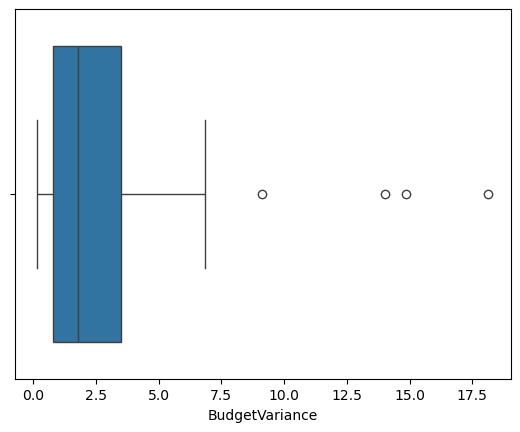

In [43]:
# Visually confirming the existence of outlairs still present.
sns.boxplot(x="BudgetVariance", data= finalmerge)
plt.show()

In [44]:
# Preparing to address catgorical variables for modeling.
encoder = OneHotEncoder(sparse_output = False, drop = 'first')

In [45]:
# Onehotencoding categorical variables for use with Linear Regression from SKLearn.
encoder.fit(finalmerge[["CompanyName","FundingType"]])
encoded_array = encoder.transform(finalmerge[["CompanyName","FundingType"]])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(["CompanyName","FundingType"]))

In [46]:
# Dropped all non-model related columns.
finalmerge_noncon = finalmerge.drop(columns=["CompanyName","FundingType"], axis=1).reset_index(drop=True)
finalmerge_con = pd.concat([finalmerge_noncon, encoded_df],axis=1)

In [47]:
# Confriming no missing values and data types are ready for modeling.
finalmerge_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 16 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OriginalBudget                                                 43 non-null     float64
 1   COvol                                                          43 non-null     float64
 2   HighForms                                                      43 non-null     float64
 3   NormalForms                                                    43 non-null     float64
 4   BudgetVariance                                                 43 non-null     float64
 5   CompanyName_C&C ELECTRICAL SERVICES LLC - 100167658            43 non-null     float64
 6   CompanyName_CARROLL DANIEL CONSTRUCTION CO - 100200909         43 non-null     float64
 7   CompanyName_KC CONSTRUCTION OF GEORGIA INC - 100194403         4

In [48]:
# Viewing data frame for formatting and project inputs.
finalmerge_con

,OriginalBudget,COvol,HighForms,NormalForms,BudgetVariance,CompanyName_C&C ELECTRICAL SERVICES LLC - 100167658,CompanyName_CARROLL DANIEL CONSTRUCTION CO - 100200909,CompanyName_KC CONSTRUCTION OF GEORGIA INC - 100194403,CompanyName_KONE INC - 100019518,CompanyName_LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,CompanyName_MCCARTHY BUILDING COMPANIES INC - 100013473,CompanyName_MIKES PAINTING & HOME IMPROVEMENT INC - 100113741,CompanyName_WEBMYERS CONSTRUCTION LLC - 100150242,CompanyName_other,FundingType_Plant Maint and Renovation (PMR),FundingType_unknown
0,1473397.04,1.0,1.0,4.0,0.642158,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1453693.36,2.0,0.0,0.0,1.408906,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,651449.03,0.0,0.0,0.0,2.179455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,287067.47,2.0,0.0,0.0,4.781606,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,601994.46,3.0,0.0,0.0,3.169579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,287599.99,2.0,0.0,0.0,2.773291,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,651564.40,0.0,0.0,0.0,1.928808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,315787.86,1.0,0.0,0.0,1.766647,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,204196.51,0.0,0.0,3.0,6.849714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,56621.93,1.0,0.0,0.0,18.133277,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [49]:
# Performing linear regression for use.
lr = LinearRegression()

In [50]:
# Defining X and y.
y = finalmerge_con["BudgetVariance"]
X = finalmerge_con.drop("BudgetVariance", axis=1)

In [51]:
# Splitting data into training and testing sets for model development and evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=31)
model_1 = lr.fit(X_train, y_train)
model_1_pred = model_1.predict(X_test)
mean_squared_error(y_test, model_1_pred)

48.13798957144632

In [52]:
# Evaluating model performance using MSE and R-squared metrics.
mean_squared_error(y_test, model_1_pred)

48.13798957144632

In [53]:
# Evaluating model performance using MSE and R-squared metrics.
r2_score(y_test, model_1_pred)

-0.7328181469390991

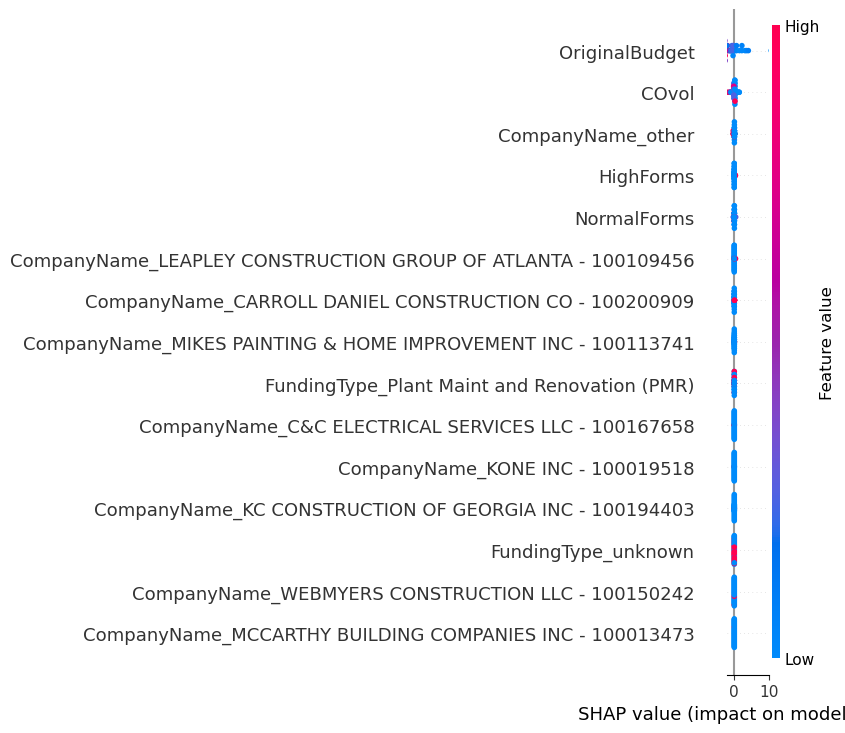

In [54]:
# Training an XGBoost regression model on the dataset. Using the results, I then identified which variables I would test for modeling as SHAP values includes of linear signifiance.

xgb_model = xgb.XGBRegressor().fit(X, y)

# 2. Calculate SHAP values
explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X)
plt.figure(figsize=(12, 12))
ax = plt.gca()              # get current axis
ax.set_xlim(-2, 10)      # set x-axis limits as you want (adjust these numbers)
shap.summary_plot(shap_values, X)



In [56]:
# Defied multiple variables for model testing to identify best performance.
y_2 = finalmerge_con["BudgetVariance"]
X_2 = finalmerge_con[["OriginalBudget", "COvol", "HighForms", "NormalForms", "FundingType_Plant Maint and Renovation (PMR)", "FundingType_unknown"]]
y_3= finalmerge_con["BudgetVariance"]
X_3 = finalmerge_con[["OriginalBudget", "COvol", "HighForms", "NormalForms"]]
y_4= finalmerge_con["BudgetVariance"]
X_4 = finalmerge_con[["OriginalBudget", "COvol"]]
y_5= finalmerge_con["BudgetVariance"]
X_5 = finalmerge_con[["OriginalBudget", "COvol", "HighForms", "NormalForms", "FundingType_Plant Maint and Renovation (PMR)"]]

In [58]:
# Created a function that allows a simple input and allows me to test different models quickly with quanitative results of the performance.
def scores (X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=31)
    model = lr.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    residuals = y_test - y_pred
    
    print(f'mse = {mse} \n r2 = {r2}')

    return model, X_test, y_pred, residuals

In [60]:
# Tested all inputs and response variable, with it achieving the lowest performance.
scores(X, y)

mse = 48.13798957144632 
 r2 = -0.7328181469390991


(LinearRegression(),
     OriginalBudget  COvol  HighForms  NormalForms  \
 19      1661177.06    0.0        0.0          0.0   
 0       1473397.04    1.0        1.0          4.0   
 2        651449.03    0.0        0.0          0.0   
 9         56621.93    1.0        0.0          0.0   
 5        287599.99    2.0        0.0          0.0   
 39      1380117.80    1.0        0.0          0.0   
 24       591714.86    0.0        2.0          0.0   
 13       910576.86    0.0        0.0          0.0   
 14       243790.99    4.0        0.0         11.0   
 
     CompanyName_C&C ELECTRICAL SERVICES LLC - 100167658  \
 19                                                0.0     
 0                                                 0.0     
 2                                                 0.0     
 9                                                 0.0     
 5                                                 0.0     
 39                                                0.0     
 24              

In [62]:
# Tested the 5th set, and it under performed.
scores(X_5, y_5)

mse = 27.23418742151673 
 r2 = 0.01965382016831807


(LinearRegression(),
     OriginalBudget  COvol  HighForms  NormalForms  \
 19      1661177.06    0.0        0.0          0.0   
 0       1473397.04    1.0        1.0          4.0   
 2        651449.03    0.0        0.0          0.0   
 9         56621.93    1.0        0.0          0.0   
 5        287599.99    2.0        0.0          0.0   
 39      1380117.80    1.0        0.0          0.0   
 24       591714.86    0.0        2.0          0.0   
 13       910576.86    0.0        0.0          0.0   
 14       243790.99    4.0        0.0         11.0   
 
     FundingType_Plant Maint and Renovation (PMR)  
 19                                           0.0  
 0                                            1.0  
 2                                            0.0  
 9                                            1.0  
 5                                            1.0  
 39                                           1.0  
 24                                           0.0  
 13                  

In [64]:
# Tested the 3th set, and it under performed.
scores(X_3, y_3)

mse = 21.527354737182893 
 r2 = 0.22508207600109964


(LinearRegression(),
     OriginalBudget  COvol  HighForms  NormalForms
 19      1661177.06    0.0        0.0          0.0
 0       1473397.04    1.0        1.0          4.0
 2        651449.03    0.0        0.0          0.0
 9         56621.93    1.0        0.0          0.0
 5        287599.99    2.0        0.0          0.0
 39      1380117.80    1.0        0.0          0.0
 24       591714.86    0.0        2.0          0.0
 13       910576.86    0.0        0.0          0.0
 14       243790.99    4.0        0.0         11.0,
 array([0.28826356, 1.29796557, 3.50751915, 5.85700171, 5.57361898,
        1.63737885, 3.71444966, 2.68135737, 6.48114349]),
 19     0.399967
 0     -0.655808
 2     -1.328064
 9     12.276275
 5     -2.800328
 39    -0.940210
 24    -0.425229
 13    -0.912292
 14    -5.562960
 Name: BudgetVariance, dtype: float64)

In [66]:
# Tested the 2th set, and it performed 2nd best.
scores(X_2, y_2)

mse = 29.711036659310228 
 r2 = -0.06950506130326417


(LinearRegression(),
     OriginalBudget  COvol  HighForms  NormalForms  \
 19      1661177.06    0.0        0.0          0.0   
 0       1473397.04    1.0        1.0          4.0   
 2        651449.03    0.0        0.0          0.0   
 9         56621.93    1.0        0.0          0.0   
 5        287599.99    2.0        0.0          0.0   
 39      1380117.80    1.0        0.0          0.0   
 24       591714.86    0.0        2.0          0.0   
 13       910576.86    0.0        0.0          0.0   
 14       243790.99    4.0        0.0         11.0   
 
     FundingType_Plant Maint and Renovation (PMR)  FundingType_unknown  
 19                                           0.0                  1.0  
 0                                            1.0                  0.0  
 2                                            0.0                  1.0  
 9                                            1.0                  0.0  
 5                                            1.0                  0.0  

In [68]:
# Tested the 4th set, and it achieved the highest performance.
scores(X_4, y_4)

mse = 21.68537041505785 
 r2 = 0.2193940022663995


(LinearRegression(),
     OriginalBudget  COvol
 19      1661177.06    0.0
 0       1473397.04    1.0
 2        651449.03    0.0
 9         56621.93    1.0
 5        287599.99    2.0
 39      1380117.80    1.0
 24       591714.86    0.0
 13       910576.86    0.0
 14       243790.99    4.0,
 array([0.27377817, 1.32431213, 3.50120857, 5.8528019 , 5.5648442 ,
        1.62246395, 3.69213906, 2.67294886, 6.60552422]),
 19     0.414452
 0     -0.682154
 2     -1.321753
 9     12.280475
 5     -2.791553
 39    -0.925295
 24    -0.402918
 13    -0.903883
 14    -5.687341
 Name: BudgetVariance, dtype: float64)

In [70]:
# Setting the highest performance model as my model for stress testing.
model, X_test, y_pred, residuals = scores(X_4, y_4)

mse = 21.68537041505785 
 r2 = 0.2193940022663995


<Axes: ylabel='BudgetVariance'>

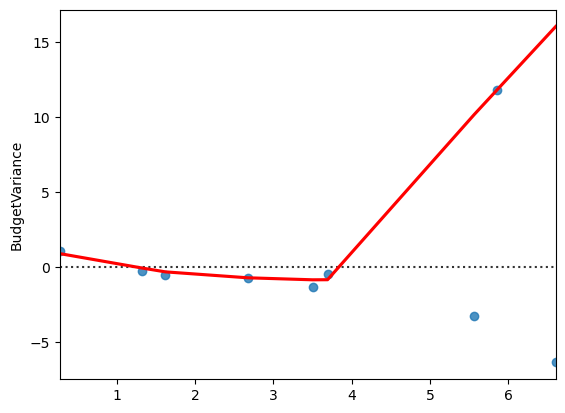

In [72]:
# Reviewed residuals, identifying they are not consistent and added understading to the lower performance it was still achiving.
sns.residplot(x=y_pred, y = residuals, lowess = True, line_kws={"color":"red"})

In [74]:
#changed columns for stress test
X_test1 = X_test.copy()
mask = X_test1["OriginalBudget"]<= 70000
X_test1.loc[mask, "OriginalBudget"] *= 1.15


X_test2 = X_test.copy()
mask = X_test2["OriginalBudget"]>= 250000
X_test2.loc[mask, "COvol"] += 2


In [76]:
# Set up function to identify how the stress test performs and provides data for visual anlysis.
def stress (X_test):
    y_stress = model.predict(X_test)
    mean_diff = np.mean(y_stress) - np.mean(y_pred)
    residual_stress =  y_pred - y_stress
    print(f'mean difference = {mean_diff}')
    return y_stress, residual_stress

In [78]:
# Completed the first stress test, verifying a minimal difference in risk when budgets for smaller projects were increased by 15 percent.
y_stress1, residual_stress1 = stress(X_test1)

mean difference = -0.0030163788789625556


In [80]:
# Completed the second stress test, veyifying a risk to projects (additional 11% variance) when change orders increased by 2.
y_stress2, residual_stress2 = stress(X_test2)

mean difference = 0.7005068941814323


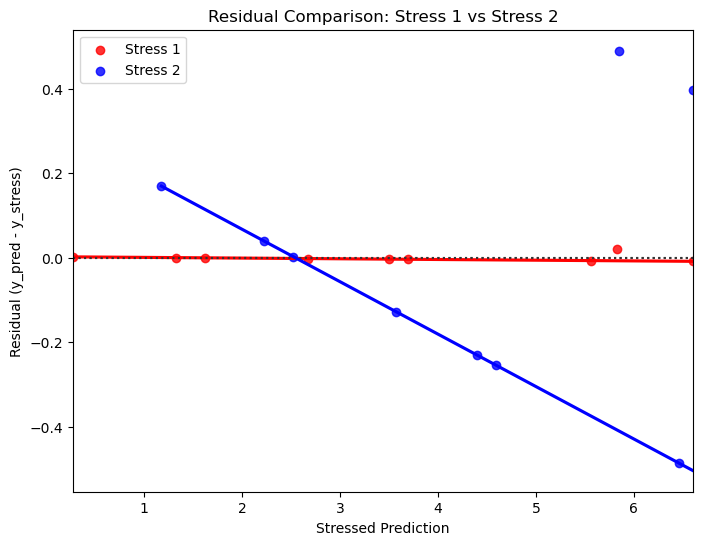

In [82]:
# Visually confirmed the first stress test did not have much impact while the second showed much more significant risk to a project if it were to occur
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.residplot(x=y_stress1, y=residual_stress1, lowess=True, color="red", label="Stress 1")
sns.residplot(x=y_stress2, y=residual_stress2, lowess=True, color="blue", label="Stress 2")
plt.title("Residual Comparison: Stress 1 vs Stress 2")
plt.xlabel("Stressed Prediction")
plt.ylabel("Residual (y_pred - y_stress)")
plt.legend()
plt.show()

In [84]:
# Completed kfold to better perform model due to small sample size.
fk = KFold(n_splits=5, shuffle=True, random_state = 31)
coefs = []
intercept=[]
mses = []
stress1_mean_diffs = []
stress2_mean_diffs = []

X = X_4
y = y_4

for train_idx, test_idx in fk.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = lr
    model.fit(X_train, y_train)

    y_kpred= model.predict(X_test)
    mse = mean_squared_error(y_test, y_kpred)

    X_test1 = X_test.copy()
    mask = X_test1["OriginalBudget"]<= 70000
    X_test1.loc[mask, "OriginalBudget"] *= 3


    X_test2 = X_test.copy()
    mask = X_test2["OriginalBudget"]>= 250000
    X_test2.loc[mask, "COvol"] += 2
    
    y_pred_stress1 = model.predict(X_test1)
    y_pred_stress2 = model.predict(X_test2)

    diff1 = y_pred_stress1.mean() - y_kpred.mean()
    diff2 = y_pred_stress2.mean() - y_kpred.mean()
    stress1_mean_diffs.append(diff1)
    stress2_mean_diffs.append(diff2)
    residuals_stress1 = y_pred_stress1 - y_kpred
    residuals_stress2 = y_pred_stress2 - y_kpred
    
    coefs.append(model.coef_)
    intercept.append(model.intercept_)
    mses.append(mse)
    
mean_coefs = np.mean(coefs, axis = 0)
mean_intercept = np.mean(intercept)
mean_mse = np.mean(mses)
mean_diff_stress1 = np.mean(stress1_mean_diffs)
mean_diff_stress2 = np.mean(stress2_mean_diffs)
print("Average Coefficients:")
for name, coef in zip(X.columns, mean_coefs):
    print(f"{name} : {coef:.4f}")
print(f"Average Intercept: {mean_intercept:.4f} \n Average MSE: {mean_mse}")
print(f"Average Stress 1 Mean Prediction Change: {mean_diff_stress1:.4f}")
print(f"Average Stress 2 Mean Prediction Change: {mean_diff_stress2:.4f}")

Average Coefficients:
OriginalBudget : -0.0000
COvol : 0.2579
Average Intercept: 5.9263 
 Average MSE: 11.612225937921904
Average Stress 1 Mean Prediction Change: -0.0189
Average Stress 2 Mean Prediction Change: 0.4024


<Axes: >

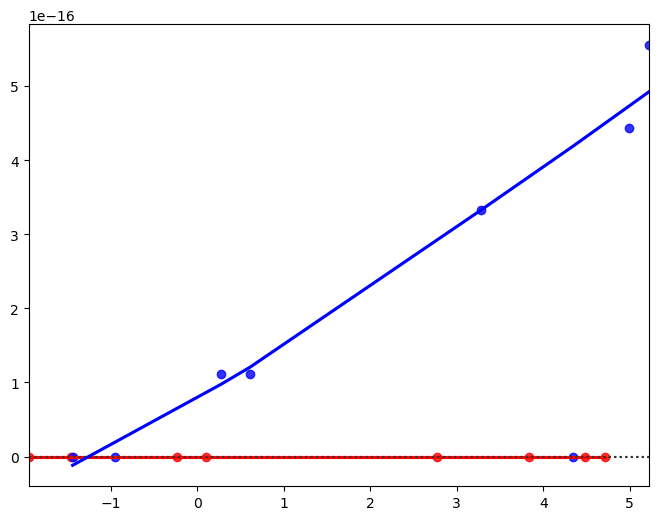

In [86]:
# Visually confrimed the first stress test still did not have significant impact while the second still has a stronger impact, but trends negative instead.
plt.figure(figsize=(8,6))
sns.residplot(x=y_pred_stress1, y=residuals_stress1, lowess = True, color="red", label = "Stress Test 1")
sns.residplot(x=y_pred_stress2, y=residuals_stress2, lowess = True, color="blue", label = "Stress Test 2")

#### Key Insights from Stress Testing

Two stress testing approaches were applied to evaluate model behavior under simulated adverse conditions:

1. **First Stress Test – Performance on Best Model (No Retraining)**:
    - Stress scenarios were directly applied to the original trained model.
    - Result: The model showed **minimal changes in predictions** when the budgets of small projects was increased by 15%.
    - Stability suggests robustness in the face of slight data perturbations.
    - When change order changes occurred with 2 more changes occuring per medium and large project, they generally **trended positively** — i.e., predictions slightly increased under stress, and showed larger risks to the budget variance as a result.

2. **Second Stress Test – Performance After K-Fold Retraining**:
    - Stressed datasets were used to retrain the model within a K-Fold cross-validation setup.
    - Result: **Larger shifts in predictions** were observed compared to the direct test.
    - The direction of the change **changed signs**:
        - **Stress test 1 predictions increased in change variation**, but averaged around zero like the original test.
        - **The K-Fold retrained model for Stress Test 2 (change orders increased by 2) showed a negative trend in predictions, with larger impacts observed across projects**. Despite the negative slope, the magnitude of the changes indicates that the model is sensitive to this stress scenario, highlighting it as a potential risk.
    - This suggests that retraining under stressed conditions induces a more conservative adjustment in the model’s structure.


### Next Steps / Recommendations
#### Updated Recommendations

1. **Model Refinement**:
    - Add polynomial or interaction terms to address nonlinearity seen in residuals.
    - Log-transform `Amount` to reduce skew and stabilize variance.
    - Use robust regression or regularization (e.g., LASSO, Ridge) to address outliers and multicollinearity.

2. **Stress Testing Integration**:
    - Continue incorporating both types of stress testing:
        - Direct stress to measure sensitivity of the current model.
        - Retrained stress to assess generalization and structural adaptation.
    - Use retraining-based stress testing when stress conditions reflect anticipated future shifts.

3. **Model Alternatives**:
    - Consider tree-based models (e.g., XGBoost, Random Forest) if linear modeling continues to fall short.

4. **Reporting**:
    - Clearly distinguish between prediction behavior from direct stress vs. retrained models.
    - Communicate the implications of diverging stress test trends to stakeholders, especially in risk-sensitive contexts.
